# Denoising EEG signals for Real-World BCI Applications using GANs

This Notebook provides the code to train and evaluate our models as part of the Paper titled "Denoising EEG signals for Real-World BCI Applications using GANs" submitted to Frontiers in Neuroergonomics 2021

## Import Modules

In [1]:
import itertools
import datetime
import time
import glob
import random
import sys

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from tqdm import tqdm
import pickle
import numpy as np
import json as js
from sklearn.metrics import mean_squared_error
from scipy import signal
from scipy.signal import find_peaks
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

If you use Google Colabs - Mount your Google Drive (otherwise skip this cell)

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/EEG-FNIRS/')

Mounted at /content/drive


### Set up GPU

In [3]:
cuda = torch.cuda.is_available()


#GPU Setup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    cuda = True
    print('Using: ' + str(torch.cuda.get_device_name(device)))
else:
    cuda = False
    print('Using: CPU')

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Using: Tesla K80


## Class Definitions

### Initialise Parameters

In [4]:
"""Initialising Parameters"""
def init_params():

  # Number of features
  seq_len = 160*4
  batch_size = 32

  # Params for the generator
  hidden_nodes_g = 50
  layers = 2
  tanh_layer = False

  num_epochs = 30
  learning_rate = 0.0002

  # Params for the Discriminator
  num_cvs = 2
  cv1_out= 10
  cv1_k = 3
  cv1_s = 1
  p1_k = 3
  p1_s = 2
  cv2_out = 10
  cv2_k = 3
  cv2_s = 1
  p2_k = 3
  p2_s = 2

  # Create Dictionary - for re-use
  params = {
      'seq_len' : seq_len,
      'batch_size' : batch_size,
      'epochs': num_epochs,
      'learning_rate' : learning_rate,
      'num_cvs' : num_cvs,
      'cv1_out' : cv1_out,
      'cv1_k' : cv1_k,
      'cv1_s' : cv1_s,
      'p1_k' : p1_k,
      'p1_s' : p1_s,
      'cv2_out' : cv2_out,
      'cv2_k' : cv2_k,
      'cv2_s' : cv2_s,
      'p2_k' : p2_k,
      'p2_s' : p2_s
  }

  return params

## Model Definitions

In [5]:
"""
Created Feb 2021

@author: Eoin Brophy

Denoising EEG - Model
"""

"""
Generator Class
---------------
This defines the Generator. The Generator consists of two LSTM 
layers with a final fully connected layer.
"""
class Generator(nn.Module):
    def __init__(self, seq_len, batch_size, n_features=2, hidden_dim=50,
                 num_layers=2, tanh_output=False):
        super(Generator, self).__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.tanh_output = tanh_output

        self.layer1 = nn.LSTM(input_size=self.n_features, hidden_size=self.hidden_dim,
                              num_layers=self.num_layers, batch_first=True,
                              )
        if self.tanh_output == True:
            self.out = nn.Sequential(nn.Linear(self.hidden_dim, self.n_features), nn.Tanh())
        else:
            self.out = nn.Linear(self.hidden_dim, self.n_features)

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, self.batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.num_layers, self.batch_size, self.hidden_dim).zero_().to(device))

        return hidden

    def forward(self, input, hidden):
        lstm_out, hidden = self.layer1(input.view(self.batch_size, self.seq_len, -1), hidden)
        lstm_out = self.out(lstm_out)

        return lstm_out


"""
Discriminator Class
---------------
This defines the Discriminator. The Discriminator consists of 4 Conv-Pool layers, 
and a fully connected layer with sigmoid activation function.
"""
class Discriminator(nn.Module):
    def __init__(self, seq_len, in_channels,
                 cv1_k, cv1_s, p1_k, p1_s,
                 cv2_k, cv2_s, p2_k, p2_s,
                 cv3_k, cv3_s, p3_k, p3_s,
                 cv4_k, cv4_s, p4_k, p4_s):
        super(Discriminator, self).__init__()
        self.seq_len = seq_len
        self.in_channels = in_channels

        self.cv1_k = cv1_k
        self.cv1_s = cv1_s
        self.cv2_k = cv2_k
        self.cv2_s = cv2_s
        self.cv3_k = cv3_k
        self.cv3_s = cv3_s
        self.cv4_k = cv4_k
        self.cv4_s = cv4_s

        self.p1_k = p1_k
        self.p1_s = p1_s
        self.p2_k = p2_k
        self.p2_s = p2_s
        self.p3_k = p3_k
        self.p3_s = p3_s
        self.p4_k = p4_k
        self.p4_s = p4_s

        cp1_out = int((((((seq_len - cv1_k) / cv1_s) + 1) - p1_k) / p1_s) + 1)
        cp2_out = int((((((cp1_out - cv2_k) / cv2_s) + 1) - p2_k) / p2_s) + 1)
        cp3_out = int((((((cp2_out - cv3_k) / cv3_s) + 1) - p3_k) / p3_s) + 1)
        cp4_out = int((((((cp3_out - cv4_k) / cv4_s) + 1) - p4_k) / p4_s) + 1)

        # The first pair of convolution-pooling layer, input size: 2*187*batch_size
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=3, kernel_size=(cv1_k), stride=(cv1_s)),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=(p1_k), stride=(p1_s))
        )

        # Second convolution - pooling layer
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=5, kernel_size=(cv2_k), stride=(cv2_s)),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=(p2_k), stride=(p2_s))
        )

        # Third convolution - pooling layer
        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=8, kernel_size=(cv3_k), stride=(cv3_s)),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=(p3_k), stride=(p3_s))
        )
        # Fourth convolution - pooling layer
        self.layer4 = nn.Sequential(
            nn.Conv1d(in_channels=8, out_channels=10, kernel_size=(cv4_k), stride=(cv4_s)),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=(p4_k), stride=(p4_s))
        )


        # Fully connected layer
        self.layer5 = nn.Sequential(
            nn.Linear(10 * cp4_out, 50),
            nn.Linear(50, 50),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)
        output = self.layer5(x)
        return output

## Function Definitions

In [6]:
def noise(batch_size, features):
    noise_vec = torch.randn(1, batch_size, features).to(device)
  
    return noise_vec

def save_params(params, filename):
    json = js.dumps(params)
    f = open(filename+'/parameters.json','w')
    f.write(json)
    f.close()

###Load Data Functions

###Load Validation Data

In [7]:
def toy_train_data(seq_len=160*4):

  train_A_data = torch.load('/content/drive/My Drive/EEG-FNIRS/Data/clean_eeg.pt')

  train_A_data = np.array(train_A_data[:12000], dtype=np.float32)
  train_A_data = torch.tensor(train_A_data)
  train_A_data = train_A_data.view(-1, 1, seq_len)


  train_B_data = torch.load('/content/drive/My Drive/EEG-FNIRS/Data/noisy_eeg.pt')


  train_B_data = np.array(train_B_data[:12000], dtype=np.float32)
  train_B_data = torch.tensor(train_B_data)
  train_B_data = train_B_data.view(-1, 1, seq_len)
  print(train_B_data.shape)

  data = []
  for i in range(len(train_A_data)):
    data.append({"A": train_A_data[i], "B": train_B_data[i]})

  # data loader
  dataloader = DataLoader(
      data,
      batch_size=32,
      shuffle=True,
      num_workers=2,
  )

  return dataloader, len(dataloader)

def toy_test_data(seq_len=160*4):

  train_A_data = torch.load('/content/drive/My Drive/EEG-FNIRS/Data/clean_eeg.pt')
  train_A_data = np.array(train_A_data[12000:12200], dtype=np.float32)
  train_A_data = torch.tensor(train_A_data)
  train_A_data = train_A_data.view(-1, 1, seq_len)


  train_B_data = torch.load('/content/drive/My Drive/EEG-FNIRS/Data/noisy_eeg.pt')
  train_B_data = np.array(train_B_data[12000:12200], dtype=np.float32)
  train_B_data = torch.tensor(train_B_data)
  train_B_data = train_B_data.view(-1, 1, seq_len)
  print(train_B_data.shape)

  data = []
  for i in range(len(train_A_data)):
    data.append({"A": train_A_data[i], "B": train_B_data[i]})

  # data loader
  dataloader = DataLoader(
      data,
      batch_size=5,
      shuffle=True,
      num_workers=2,
  )

  return dataloader, len(dataloader)

### Load Model

Loads the models and sets up their optimisers 

In [8]:
def load_model(params):

    # Initialize generator and discriminator
    G = Generator(params['seq_len'], params['batch_size'], n_features=1, hidden_dim = 50, tanh_output = False).to(device)

    D = Discriminator(params['seq_len'], in_channels=1,
                              cv1_k=3, cv1_s=1, p1_k=3, p1_s=1,
                              cv2_k=3, cv2_s=1, p2_k=3, p2_s=2,
                              cv3_k=3, cv3_s=2, p3_k=3, p3_s=2,
                              cv4_k=5, cv4_s=2, p4_k=5, p4_s=2).to(device)

    

    # Optimizers
    optimizer_G = torch.optim.Adam(G.parameters(), lr = params['learning_rate'], betas=(0.5, 0.999))

    optimizer_D = torch.optim.Adam(D.parameters(), lr = params['learning_rate'], betas=(0.5, 0.999))
    
    
    return G, D, optimizer_G, optimizer_D

### Training Function

In [9]:
# Losses
criterion_GAN = nn.MSELoss().to(device)


def train_LSgan(params, savepath = '/content/drive/My Drive/EEG-FNIRS/EEG_2_Results/'):
    # Load data
    data_loader, num_batches = load_training_data()

    # Save Parameters
    save_params(params, savepath)

    G_losses = []
    D_losses =[]
    # Load model
    G, D, optimizer_G, optimizer_D = load_model(params)
    
    G.train()
    D.train()
    
    prev_time = time.time()

    for n in tqdm(range(params['epochs'])):
      for n_batch, sample_data in enumerate(data_loader):
          # Set model input
          clean_eeg = Variable(sample_data["A"].type(Tensor)) # Clean
          noisy_eeg = Variable(sample_data["B"].type(Tensor)) # Noisy

          # Adversarial GT
          valid = Variable(Tensor(clean_eeg.size(0), 1).fill_(1.0), requires_grad=False)
          fake = Variable(Tensor(clean_eeg.size(0), 1).fill_(0.0), requires_grad=False)

          # ------------------
          #  Train Generator
          # ------------------
          optimizer_G.zero_grad()
          h_g = G.init_hidden()

          # Generate a batch of denoised data
          denoised_data = generator.forward(noisy_eeg,h_g)#.detach()
          denoised_data = denoised_data.view(params['batch_size'], -1, params['seq_len'])

          # Loss measures generator's ability to fool the discriminator
          loss_G = criterion_GAN(D(denoised_data), valid)

          loss_G.backward()
          optimizer_G.step()

          # -----------------------
          #  Train Discriminator A
          # -----------------------
          optimizer_D.zero_grad()

          # Get a batch of real data and 
          # Measure discriminator's ability to classify real from generated samples
          real_loss = criterion_GAN(D(clean_data), valid)
          fake_loss = criterion_GAN(D(denoised_data.detach()), fake)

          loss_D = (0.5 * (real_loss + fake_loss))

          loss_D.backward()
          d_optimizer.step()

          
          # --------------
          #  Log Progress
          # --------------

          # Determine approximate time left
          batches_done = n * len(data_loader) + n_batch
          batches_left = params['epochs'] * num_batches - batches_done
          time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
          prev_time = time.time()

            
          if n_batch == (num_batches-1):

            # Print log
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f] ETA: %s \n"
                % (
                    n,
                    params['epochs'],
                    n_batch,
                    len(data_loader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_GAN.item(),
                    time_left,
                )
            )
            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())

            torch.save(G.state_dict(), savepath+'/gen/G_state_'+str(n)+'.pt')
            torch.save(D.state_dict(), savepath+'/disc/D_state_'+str(n)+'.pt')
                                   
        # Dumping the errors for each training epoch.
      with open(savepath+'/generator_losses.txt', 'wb') as fp:
        pickle.dump(loss_G, fp)
      with open(savepath+'/discriminator_losses.txt', 'wb') as fp:
        pickle.dump(loss_D, fp) 

## Main - calls training function

In [10]:
# Initialise Parameters
parameters = init_params()
# Choose GAN function to use
#train_LSgan(params=parameters)



---



---




# Testing the Trained EEG Denoising model 

note: the models have different input sequence length based on the artefact as the artefacts were sampled at differing frequencies.


In [12]:
# Load two generators and validation data
val_dataloader, verbose = toy_test_data()
savepath = '/content/drive/My Drive/EEG-FNIRS/EEG_50_Results/'

G = Generator(parameters['seq_len'], 5, 
                 n_features=1, hidden_dim = 50,
                 tanh_output = False).to(device) 
G.load_state_dict(torch.load(savepath+'/gen/G_state_19.pt'))

torch.Size([200, 1, 640])


<All keys matched successfully>

In [13]:
G.eval()
h_g = G.init_hidden()

In [16]:
def test_Gen(val_dataloader, G, h_g, params):

  for n_batch, test_data in enumerate(val_dataloader):
    clean_test = Variable(test_data["A"].type(Tensor))
    noisy_test = Variable(test_data["B"].type(Tensor))
    cleaned_test = G(noisy_test[:,:,:], h_g)
    cleaned_test = cleaned_test.view(5, -1, params['seq_len'])


  return clean_test, noisy_test, cleaned_test

In [17]:
clean_eeg, noisy_eeg, cleaned_eeg = test_Gen(val_dataloader,G, h_g, parameters)

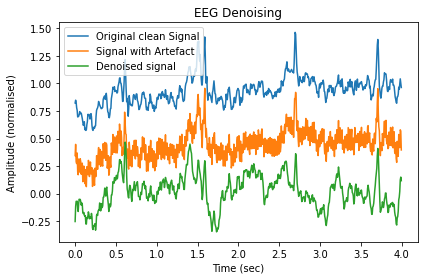

In [18]:
Fs = 160
Ts = 1.0/Fs
sig_len = len(clean_eeg[0,0,:].detach().cpu().numpy())//Fs
t = np.arange(0, sig_len, Ts)

plt.plot(t, clean_eeg[0,0,:].detach().cpu().numpy()+0.5, label = 'Original clean Signal')
plt.plot(t, noisy_eeg[0,0,:].detach().cpu().numpy(), label = 'Signal with Artefact')
plt.plot(t, cleaned_eeg[0,0,:].detach().cpu().numpy() - 0.5, label = 'Denoised signal' )
plt.title('EEG Denoising')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (normalised)')
plt.legend()
plt.tight_layout()

#clean_sine.shape

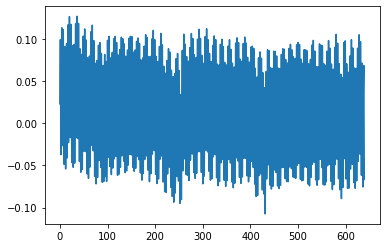

In [19]:
plt.plot(noisy_eeg[0,0,:].detach().cpu().numpy() - clean_eeg[0,0,:].detach().cpu().numpy(), label = 'Original Noise')

## Setup test loop

In [20]:
from scipy import signal as sig

# Power Spectral Density of EEG
def calcPSD(signal):
  freqs, psd = sig.welch(signal, fs=160.0, nfft=len(signal), nperseg=len(signal))
  return freqs, psd

# Power Spectral Density of EEG
def plot_PSD(clean,noisy,denoised):
  # Hardcoded Frequency Bands of EEG for
  # plotting 
  delta =  [1,4]
  theta = [4,8] 
  alpha = [8,13] 
  beta = [13,30]
  gamma = [30,80]

  # PSD of the Clean (ground-truth) Signal
  freqs, psd = sig.welch(clean, fs=160.0, nfft=len(clean), nperseg=len(clean))

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))

  ax1.plot(freqs,psd, c='dodgerblue')
  ax1.axvspan(delta[0], delta[1], alpha=0.3, color='red')  
  ax1.axvspan(theta[0], theta[1], alpha=0.3, color='orange') 
  ax1.axvspan(alpha[0], alpha[1], alpha=0.3, color='yellow') 
  ax1.axvspan(beta[0], beta[1],   alpha=0.3, color='green') 
  ax1.axvspan(gamma[0], gamma[1], alpha=0.3, color='purple') 
  ax1.set_xlim(0,80)

  ax1.set_title("Clean Signal")
  ax1.set_ylabel("Power [V**2/Hz]")
  ax1.set_xlabel("Frequency (Hz)")

  # PSD of the Noisy Signal
  freqs, psd = sig.welch(noisy, fs=160.0, nfft=len(noisy), nperseg=len(noisy))

  ax2.plot(freqs,psd, c='dodgerblue')
  ax2.axvspan(delta[0], delta[1], alpha=0.3, color='red')  
  ax2.axvspan(theta[0], theta[1], alpha=0.3, color='orange') 
  ax2.axvspan(alpha[0], alpha[1], alpha=0.3, color='yellow') 
  ax2.axvspan(beta[0], beta[1],   alpha=0.3, color='green') 
  ax2.axvspan(gamma[0], gamma[1], alpha=0.3, color='purple') 
  ax2.set_xlim(0,80)

  ax2.set_title("Contaminated Signal")
  ax2.set_ylabel("Power [V**2/Hz]")
  ax2.set_xlabel("Frequency (Hz)")

  # PSD of the Denoised Signal
  freqs, psd = sig.welch(denoised, fs=160.0, nfft=len(denoised), nperseg=len(denoised))

  ax3.plot(freqs,psd, c='dodgerblue')
  ax3.axvspan(delta[0], delta[1], alpha=0.3, color='red')  
  ax3.axvspan(theta[0], theta[1], alpha=0.3, color='orange') 
  ax3.axvspan(alpha[0], alpha[1], alpha=0.3, color='yellow') 
  ax3.axvspan(beta[0], beta[1],   alpha=0.3, color='green') 
  ax3.axvspan(gamma[0], gamma[1], alpha=0.3, color='purple') 
  ax3.set_xlim(0,80)

  ax3.set_title("Denoised Signal")
  ax3.set_ylabel("Power [V**2/Hz]")
  ax3.set_xlabel("Frequency (Hz)")

  plt.tight_layout()
  #plt.savefig('PSD_50.pdf',format='pdf')

In [21]:
# Power Ratio of Frequency Bands
def power_Ratio(x_freq, xPSD):
  freq_bands = [1,4,8,13,30,80]
  power_ratio = []
  for i in range(len(freq_bands)-1):
    idx = (x_freq>=freq_bands[i])*(x_freq<=freq_bands[i+1])
    #print(np.where(idx))
    #print(np.sum(xPSD[idx]))
    power_ratio.append(np.sum(xPSD[idx]))
  power_ratio = np.array(power_ratio)
  return power_ratio/power_ratio.sum()

In [22]:
# Spectral RRMSE
def RRMSE_S(PSDx, PSDfy):
  rrmse = []

  RMS_signal = 1/len(PSDx) * np.sum((PSDfy-PSDx)**2)
  RMS_noise = 1/len(PSDx) * np.sum((PSDx)**2)

  x = RMS_signal/RMS_noise
  rrmse.append(x)
  rrmse = np.array(rrmse)
  return rrmse

In [23]:
# Temporal RRMSE
def RRMSE_T(signal, cleaned_signal):
  rrmse = []
  for i in range(len(cleaned_signal)):
    f_y = cleaned_signal[i,0,:]
    x = signal[i,0,:]
    RMS_signal = 1/len(f_y) * torch.sum((f_y-x)**2)
    RMS_noise = 1/len(x) * torch.sum((x)**2)

    x = RMS_signal/RMS_noise
    rrmse.append(x.detach().cpu().numpy())
  rrmse = np.array(rrmse)
  return rrmse

In [24]:
# SNR Metrics
# - for ground-truth
def SNR_GT(signal, noisey_signal):
  SNR = []
  for i in range(len(signal)):
    noise = noisey_signal[i,0,:] - signal[i,0,:]
    RMS_signal = 1/len(signal[i,0,:]) * torch.sum(signal[i,0,:]**2)
    RMS_noise = 1/len(noise) * torch.sum((1*noise)**2)
    
    x = 10*torch.log10(RMS_signal/RMS_noise)
    SNR.append(x.detach().cpu().numpy())
  SNR = np.array(SNR)
  return SNR

# - for cleaned-signal & noisy signal
def SNR_cleaned(signal, noisey_signal, cleaned_signal):
  SNR = []
  for i in range(len(signal)):
    #noise = cleaned_signal[i,0,:] - signal[i,0,:]
    noise = noisey_signal[i,0,:] - signal[i,0,:]
    RMS_signal = 1/len(cleaned_signal[i,0,:]) * torch.sum(cleaned_signal[i,0,:]**2)
    RMS_noise = 1/len(noise) * torch.sum((1*noise)**2)
    
    x = 10*torch.log10(RMS_signal/RMS_noise)
    SNR.append(x.detach().cpu().numpy())
  SNR = np.array(SNR)
  return np.around(SNR, decimals=4)

In [26]:
from scipy.stats import pearsonr

# Test the EEG Metrics
def test_EEG_Gen(val_dataloader, G, h_g, params):
  SNR_gt = []
  SNR_model = []
  rrmse_t = []
  X_FreqList = []
  X_PSDList = []
  N_FreqList = []
  N_PSDList = []
  Fy_FreqList = []
  Fy_PSDList = []
  rrmse_sList = []
  powerRatio_ListGT = []
  powerRatio_ListM = []
  powerRatio_ListN = []
  CC = []

  # Iterate over the test dataset
  for n_batch, test_data in enumerate(val_dataloader):
    clean_eeg = Variable(test_data["A"].type(Tensor))
    noisy_eeg = Variable(test_data["B"].type(Tensor))
    cleaned_eeg = G(noisy_eeg[:,:,:], h_g)
    cleaned_eeg = cleaned_eeg.view(5, -1, params['seq_len'])

    ## ======= Calculate Metrics from functions defined above ======== ##
    SNR_gt.append(SNR_GT(clean_eeg, noisy_eeg))
    SNR_model.append(SNR_cleaned(clean_eeg, noisy_eeg, cleaned_eeg))
    rrmse_t.append(RRMSE_T(clean_eeg, cleaned_eeg))

    for i in range(len(clean_eeg)):
      # PSD for clean EEG
      x_freq, xPSD = calcPSD(clean_eeg[i,0,:].detach().cpu().numpy())
      # PSD for denoised EEG
      fy_freq, f_yPSD = calcPSD(cleaned_eeg[i,0,:].detach().cpu().numpy())
      # PSD for noisy EEG
      n_freq, nPSD = calcPSD(noisy_eeg[i,0,:].detach().cpu().numpy())

      # RRMSE Spectral for denoised signal
      rrmse_s = RRMSE_S(xPSD, f_yPSD)

      # Power Ratios of ground-truth frequencies
      pRatioGT = power_Ratio(x_freq,xPSD)
      # Power Ratios of denoised frequencies
      pRatioModel = power_Ratio(fy_freq,f_yPSD)
      # Power Ratios of noisy frequencies
      pRatioN = power_Ratio(n_freq, nPSD)

      # CC of denoised EEG
      cc, _ = pearsonr(cleaned_eeg[i,0,:].detach().cpu().numpy(), clean_eeg[i,0,:].detach().cpu().numpy())

      X_FreqList.append(x_freq)
      X_PSDList.append(xPSD)
      #N_FreqList.append(n_freq)
      #N_PSDList.append(nPSD)
      Fy_FreqList.append(fy_freq)
      Fy_PSDList.append(f_yPSD)
      rrmse_sList.append(rrmse_s)
      powerRatio_ListGT.append(pRatioGT)
      powerRatio_ListM.append(pRatioModel)
      powerRatio_ListN.append(pRatioN)
      CC.append(cc)


  return SNR_gt,SNR_model,rrmse_t,X_FreqList,X_PSDList,Fy_FreqList,Fy_PSDList, rrmse_sList,powerRatio_ListGT, powerRatio_ListM,powerRatio_ListN, CC

## Run Test FCNs

In [27]:
SNR_gt,SNR_model,rrmse_t,X_FreqList,X_PSDList,Fy_FreqList,Fy_PSDList,rrmse_sList,powerRatio_ListGT,powerRatio_ListM,powerRatio_ListN,CC = test_EEG_Gen(val_dataloader,G, h_g, parameters)


In [28]:
# Checking Shapes - sanity check
print(np.array(SNR_gt).flatten().shape)
print(np.array(SNR_model).flatten().shape)
print(np.array(rrmse_t).flatten().shape)
print(np.array(rrmse_sList).flatten().shape)
print(np.array(CC).flatten().shape)

print(np.array(powerRatio_ListGT).shape)
print(np.array(powerRatio_ListM).shape)

(200,)
(200,)
(200,)
(200,)
(200,)
(200, 5)
(200, 5)


In [29]:
# SNR for clean ground-truth signals
gtSNR = np.array(SNR_gt).flatten()
# SNR for denoised signals
mSNR  = np.array(SNR_model).flatten()

In [30]:
# Temporal/Spectral RRMSE and Correlation Coefficient
rrmse_t = np.array(rrmse_t).flatten()
rrmse_s = np.array(rrmse_sList).flatten()
cc = np.array(CC).flatten()

In [31]:
# Power ratios of Ground-truth, Denoised and Noisy Signals Respectively
powerGT = np.array(powerRatio_ListGT)
powerM = np.array(powerRatio_ListM)
powerN = np.array(powerRatio_ListN)

In [32]:
# Rounding the SNR to nearest int, 
# there was mainly 0.000x SNR levels removed
gtSNR = (np.around(gtSNR, decimals=0))
# Print Unique SNR levels
print(np.unique(gtSNR))

[15. 16. 17. 18. 19.]


In [33]:
dBlevels = np.unique(gtSNR)

# x list to store dB levels, SNR, RRMSE temporal and spectral, and CC of denoised signal
x=[]

# lists for Frequency Power Levels of: Ground-truth, Denoised and Noisy Signals
y_pgt = []
y_pm = []
y_n = []

for i in dBlevels:
  idx = np.where(gtSNR == i)
  x.append((i, np.mean(mSNR[idx]), np.mean(rrmse_t[idx]), np.mean(rrmse_s[idx]), np.mean(cc[idx]) ))
  y_pgt.append((i, np.mean(powerGT[idx,0]), np.mean(powerGT[idx,1]),
                np.mean(powerGT[idx,2]), np.mean(powerGT[idx,3]), 
                np.mean(powerGT[idx,4])))
  y_pm.append((i, np.mean(powerM[idx,0]), np.mean(powerM[idx,1]),
                np.mean(powerM[idx,2]), np.mean(powerM[idx,3]), 
                np.mean(powerM[idx,4])))
  y_n.append((i, np.mean(powerN[idx,0]), np.mean(powerN[idx,1]),
                np.mean(powerN[idx,2]), np.mean(powerN[idx,3]), 
                np.mean(powerN[idx,4])))

In [34]:
dBlevels = np.unique(gtSNR)
x_rrmse_t=[]
x_cc = []
for i in dBlevels:
  idx = np.where(gtSNR == i)
  x_rrmse_t.append((i,  rrmse_t[idx] ))
  x_cc.append((i,  cc[idx] ))
x_rrmse_t = np.array(x_rrmse_t)
x_cc = np.array(x_cc)
print(x_rrmse_t.shape)
print(x_cc.shape)

(5, 2)
(5, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


In [35]:
x = np.array(x)
y_pgt = np.array(y_pgt)
y_pm = np.array(y_pm)
y_n = np.array(y_n)

print(x.shape)
print(y_pgt.shape, y_pm.shape)

(5, 5)
(5, 6) (5, 6)


In [ ]:
# Power Levels for ground-truth clean signals
for i in range(len(y_pgt)):
  print("SNR_level: "+str(y_pgt[:,0][i]))
  print("Power_Ratio: " +str(y_pgt[i,1:]))

SNR_level: 15.0
Power_Ratio: [0.5048782  0.12408168 0.21479858 0.12376907 0.03247249]
SNR_level: 16.0
Power_Ratio: [0.54385525 0.15132716 0.1683051  0.10559704 0.03091544]
SNR_level: 17.0
Power_Ratio: [0.58721817 0.13836008 0.14786121 0.09448489 0.0320757 ]
SNR_level: 18.0
Power_Ratio: [0.6101485  0.12592155 0.1548213  0.07629505 0.03281365]
SNR_level: 19.0
Power_Ratio: [0.7102653  0.15377691 0.06115989 0.05308617 0.02171165]


In [ ]:
# Power Levels for denoised signals
for i in range(len(y_pgt)):
  print("SNR_level: "+str(y_pm[:,0][i]))
  print("Power_Ratio: " +str(y_pm[i,1:]))

SNR_level: 15.0
Power_Ratio: [0.53781575 0.12639749 0.20181598 0.09466078 0.03931003]
SNR_level: 16.0
Power_Ratio: [0.5693809  0.15386248 0.15937921 0.07985774 0.03751976]
SNR_level: 17.0
Power_Ratio: [0.6086137  0.14099464 0.14057574 0.07114109 0.03867485]
SNR_level: 18.0
Power_Ratio: [0.6264194  0.12850992 0.14786561 0.05690753 0.04029751]
SNR_level: 19.0
Power_Ratio: [0.7239068  0.15624017 0.05529497 0.03868229 0.02587576]


In [ ]:
# Power Levels for noisy signals
for i in range(len(y_pgt)):
  print("SNR_level: "+str(y_n[:,0][i]))
  print("Power_Ratio: " +str(y_n[i,1:]))

SNR_level: 15.0
Power_Ratio: [0.3653204  0.08132356 0.1412179  0.07883359 0.33330452]
SNR_level: 16.0
Power_Ratio: [0.41134897 0.1018734  0.11017537 0.06749558 0.3091067 ]
SNR_level: 17.0
Power_Ratio: [0.43658668 0.0946471  0.09547723 0.05962148 0.31366748]
SNR_level: 18.0
Power_Ratio: [0.47387108 0.09370497 0.11064221 0.05343552 0.26834625]
SNR_level: 19.0
Power_Ratio: [0.5429484  0.11755177 0.04675251 0.0405807  0.25216657]


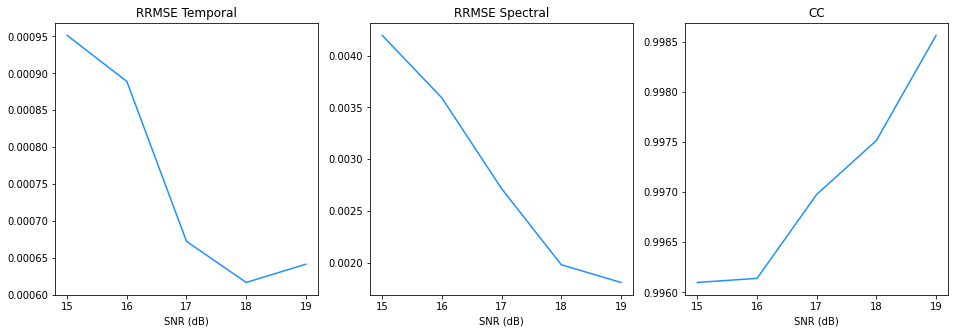

In [ ]:
# Plotting RRMSE temporal, spectral and CC 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
ax1.set_title("RRMSE Temporal")
ax1.plot(x[:,0], x[:,2], c='dodgerblue')
ax1.set_xticks(x[:,0])
ax1.set_xlabel("SNR (dB)")

ax2.set_title("RRMSE Spectral")
ax2.plot(x[:,0], x[:,3], c='dodgerblue')
ax2.set_xticks(x[:,0])
ax2.set_xlabel("SNR (dB)")

ax3.set_title("CC")
ax3.set_xlabel("SNR (dB)")
ax3.plot(x[:,0], x[:,4], c='dodgerblue')
ax3.set_xticks(x[:,0])

#plt.savefig('./RRMSE_CC_50.pdf', format='pdf')
#plt.show() 

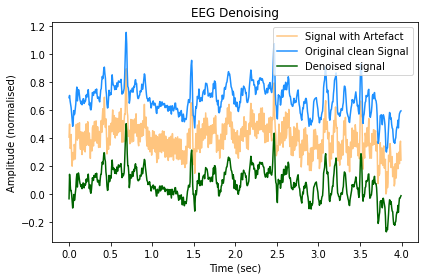

In [ ]:
# Plot example of EEG ground-truth, denoised and noisy signals
sample_data = iter(val_dataloader).next()
clean_eeg = Variable(sample_data["A"].type(Tensor))
noised_eeg = G_AB(clean_eeg[:,:,:], h_g_AB)
noised_eeg = noised_eeg.view(5, -1, parameters['seq_len'])

noisy_eeg = Variable(sample_data["B"].type(Tensor))
cleaned_eeg = G_BA(clean_eeg[:,:,:], h_g_BA)
cleaned_eeg = noised_eeg.view(5, -1, parameters['seq_len'])

Fs = 160.0
Ts = 1.0/Fs
sig_len = len(clean_eeg[0,0,:].detach().cpu().numpy())//Fs
t = np.arange(0, sig_len, Ts)

plt.plot(t, noisy_eeg[0,0,:].detach().cpu().numpy(), label = 'Signal with Artefact', alpha=0.5, c='darkorange')
plt.plot(t, clean_eeg[0,0,:].detach().cpu().numpy()+0.3, label = 'Original clean Signal', c='dodgerblue')
plt.plot(t, cleaned_eeg[0,0,:].detach().cpu().numpy() - 0.3, label = 'Denoised signal', c='darkgreen' )
plt.title('EEG Denoising')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (normalised)')
plt.legend()
plt.tight_layout()
#plt.savefig('./EEG_50_Denoising_5.pdf',format='pdf')
#clean_sine.shape

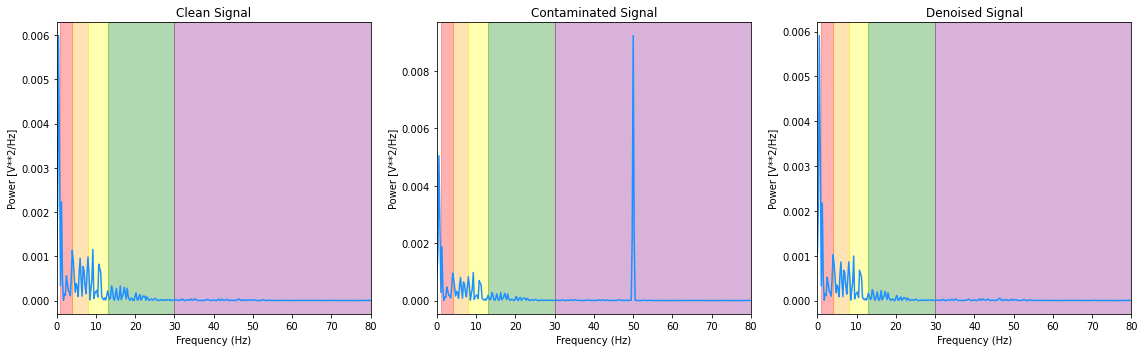

In [ ]:
# Plost PSD
plot_PSD(clean_eeg[0,0,:].detach().cpu().numpy(), noisy_eeg[0,0,:].detach().cpu().numpy(), cleaned_eeg[0,0,:].detach().cpu().numpy())

## Test EOG model on EEG-50 apparent EOG artefact - need to resample data firstly

Load 50Hz noisy data and Denoise it with 50Hz model

In [ ]:
savepath = '/content/drive/My Drive/EEG-FNIRS/GAN_toy_Results/'

# Load two generators and validation data
test_dataloader, verbose = toy_test_data()
seq_len = 160*4
G = Generator(seq_len, 5, 
                 n_features=1, hidden_dim = 50,
                 tanh_output = False).to(device) 
G.load_state_dict(torch.load(savepath+'/G_state_7.pt', map_location=torch.device(device)))

G.eval()
h_g = G.init_hidden()

torch.Size([200, 1, 640])


Get example of denoised 50Hz with apparent EoG artefact

In [ ]:
test_data = iter(test_dataloader).next()
clean_test = Variable(test_data["A"].type(Tensor))
noisy_test = Variable(test_data["B"].type(Tensor))
cleaned_test = G(noisy_test[:,:,:], h_g)
cleaned_test = cleaned_test.view(5, -1, seq_len)

Plot them

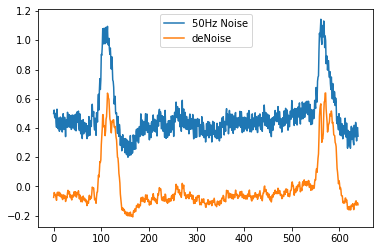

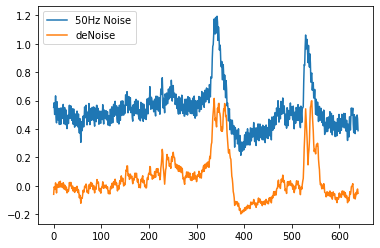

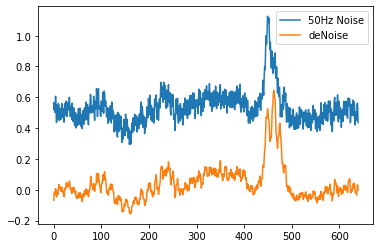

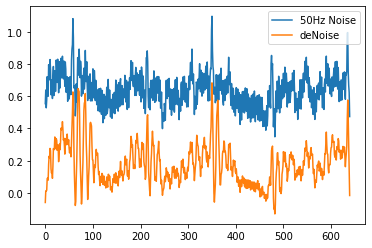

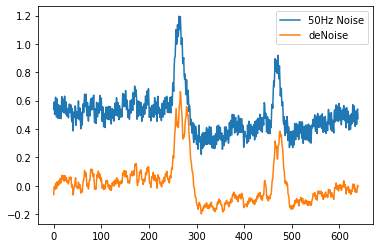

In [ ]:
for i in range(len(cleaned_test)):
  plt.figure()
  plt.plot(noisy_test[i,0,:].detach().cpu().numpy()+0.2, label='50Hz Noise')
  plt.plot(cleaned_test[i,0,:].detach().cpu().numpy()-0.2, label='deNoise')
  plt.legend()

Upsample to match EOG Model

In [ ]:
from scipy import signal

resamp_artefacts = []
for i in range(len(cleaned_test)):
  x = cleaned_test[i,0,:]
  y = signal.resample(x.detach().cpu().numpy(),1024)
  
  resamp_artefacts.append(y)

resamp_artefacts = np.array(resamp_artefacts)
resamp_artefacts = torch.tensor(resamp_artefacts[:,:512])
resamp_artefacts = Variable(resamp_artefacts.type(Tensor))

resamp_artefacts = resamp_artefacts.view(-1, 1, 512)
print(resamp_artefacts.shape)

torch.Size([5, 1, 512])


Plot them

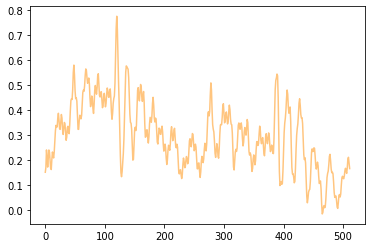

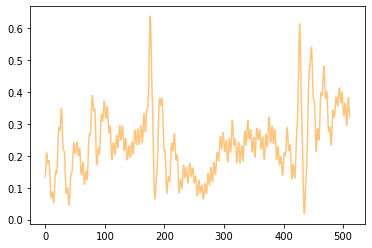

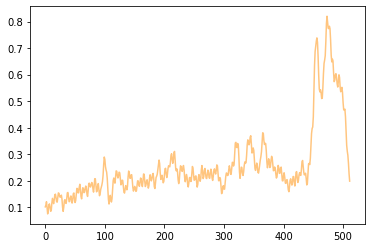

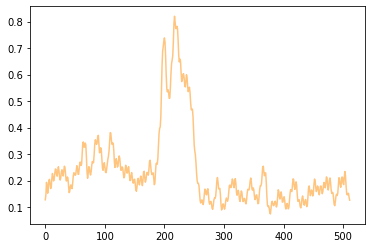

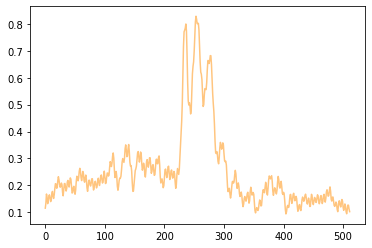

In [ ]:
for i in range(len(resamp_artefacts)):
  plt.figure()
  plt.plot(resamp_artefacts[i,0,:].detach().cpu().numpy(), label = 'Signal with Artefact', alpha=0.5, c='darkorange')

Load EOG model to try remove EOG artefact

In [ ]:
savepath = '/content/drive/My Drive/EEG-FNIRS/GAN_EOG_Results/'
# Load generator
G = Generator(512, 5, 
                 n_features=1, hidden_dim = 50,
                 tanh_output = False).to(device) 
G.load_state_dict(torch.load(savepath+'/G_state_7.pt', map_location=torch.device(device)))

G.eval()
h_g = G.init_hidden()

In [ ]:
cleaned_eog = G(resamp_artefacts[:,:,:], h_g)
cleaned_eog = cleaned_eog.view(5, -1, 512)

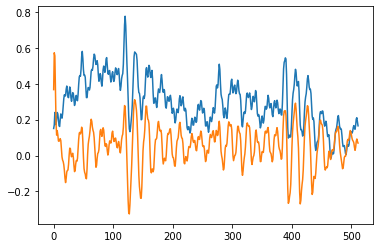

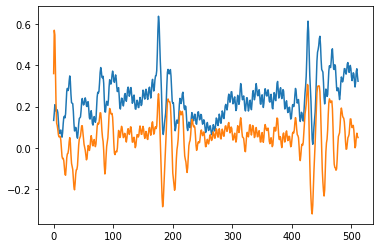

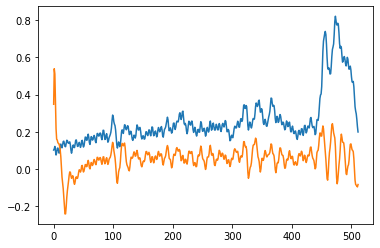

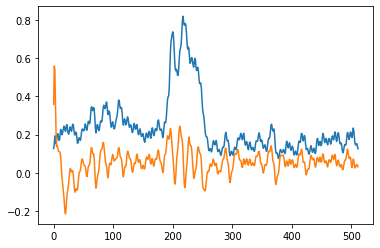

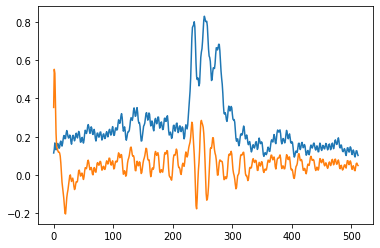

In [ ]:
for i in range(len(cleaned_eog)):
  plt.figure()
  plt.plot(resamp_artefacts[i,0,:].detach().cpu().numpy())
  plt.plot(cleaned_eog[i,0,:].detach().cpu().numpy())

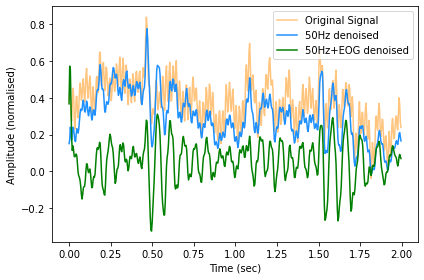

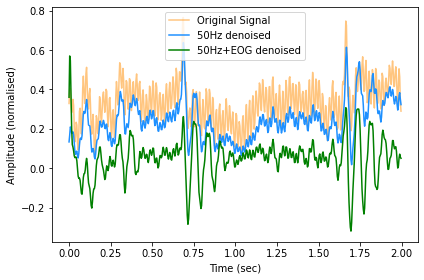

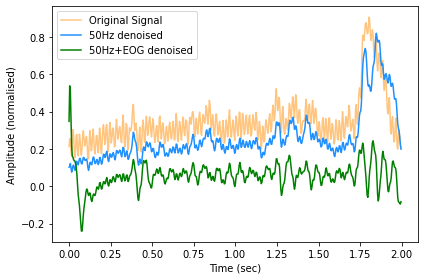

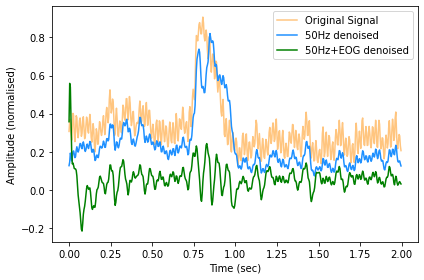

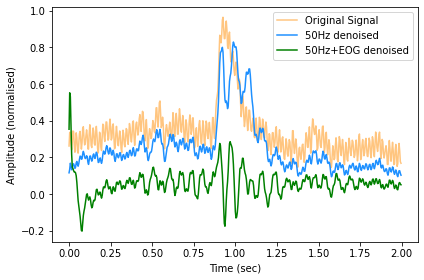

In [ ]:
Fs = 256.0
Ts = 1.0/Fs
sig_len = len(cleaned_eog[0,0,:].detach().cpu().numpy())//Fs
t = np.arange(0, sig_len, Ts)

for i in range(len(cleaned_eog)):
  plt.figure()
  plt.xlabel('Time (sec)')
  plt.ylabel('Amplitude (normalised)')
  plt.plot(t, noise[i,0,:].detach().cpu().numpy(), c='darkorange', label='Original Signal', alpha =0.5)
  plt.plot(t, resamp_artefacts[i,0,:].detach().cpu().numpy(), c='dodgerblue', label='50Hz denoised')
  plt.plot(t, cleaned_eog[i,0,:].detach().cpu().numpy(), c='green', label='50Hz+EOG denoised')
  plt.tight_layout()
  plt.legend()
  plt.savefig('./fig_%i.pdf'%(i), format='pdf')